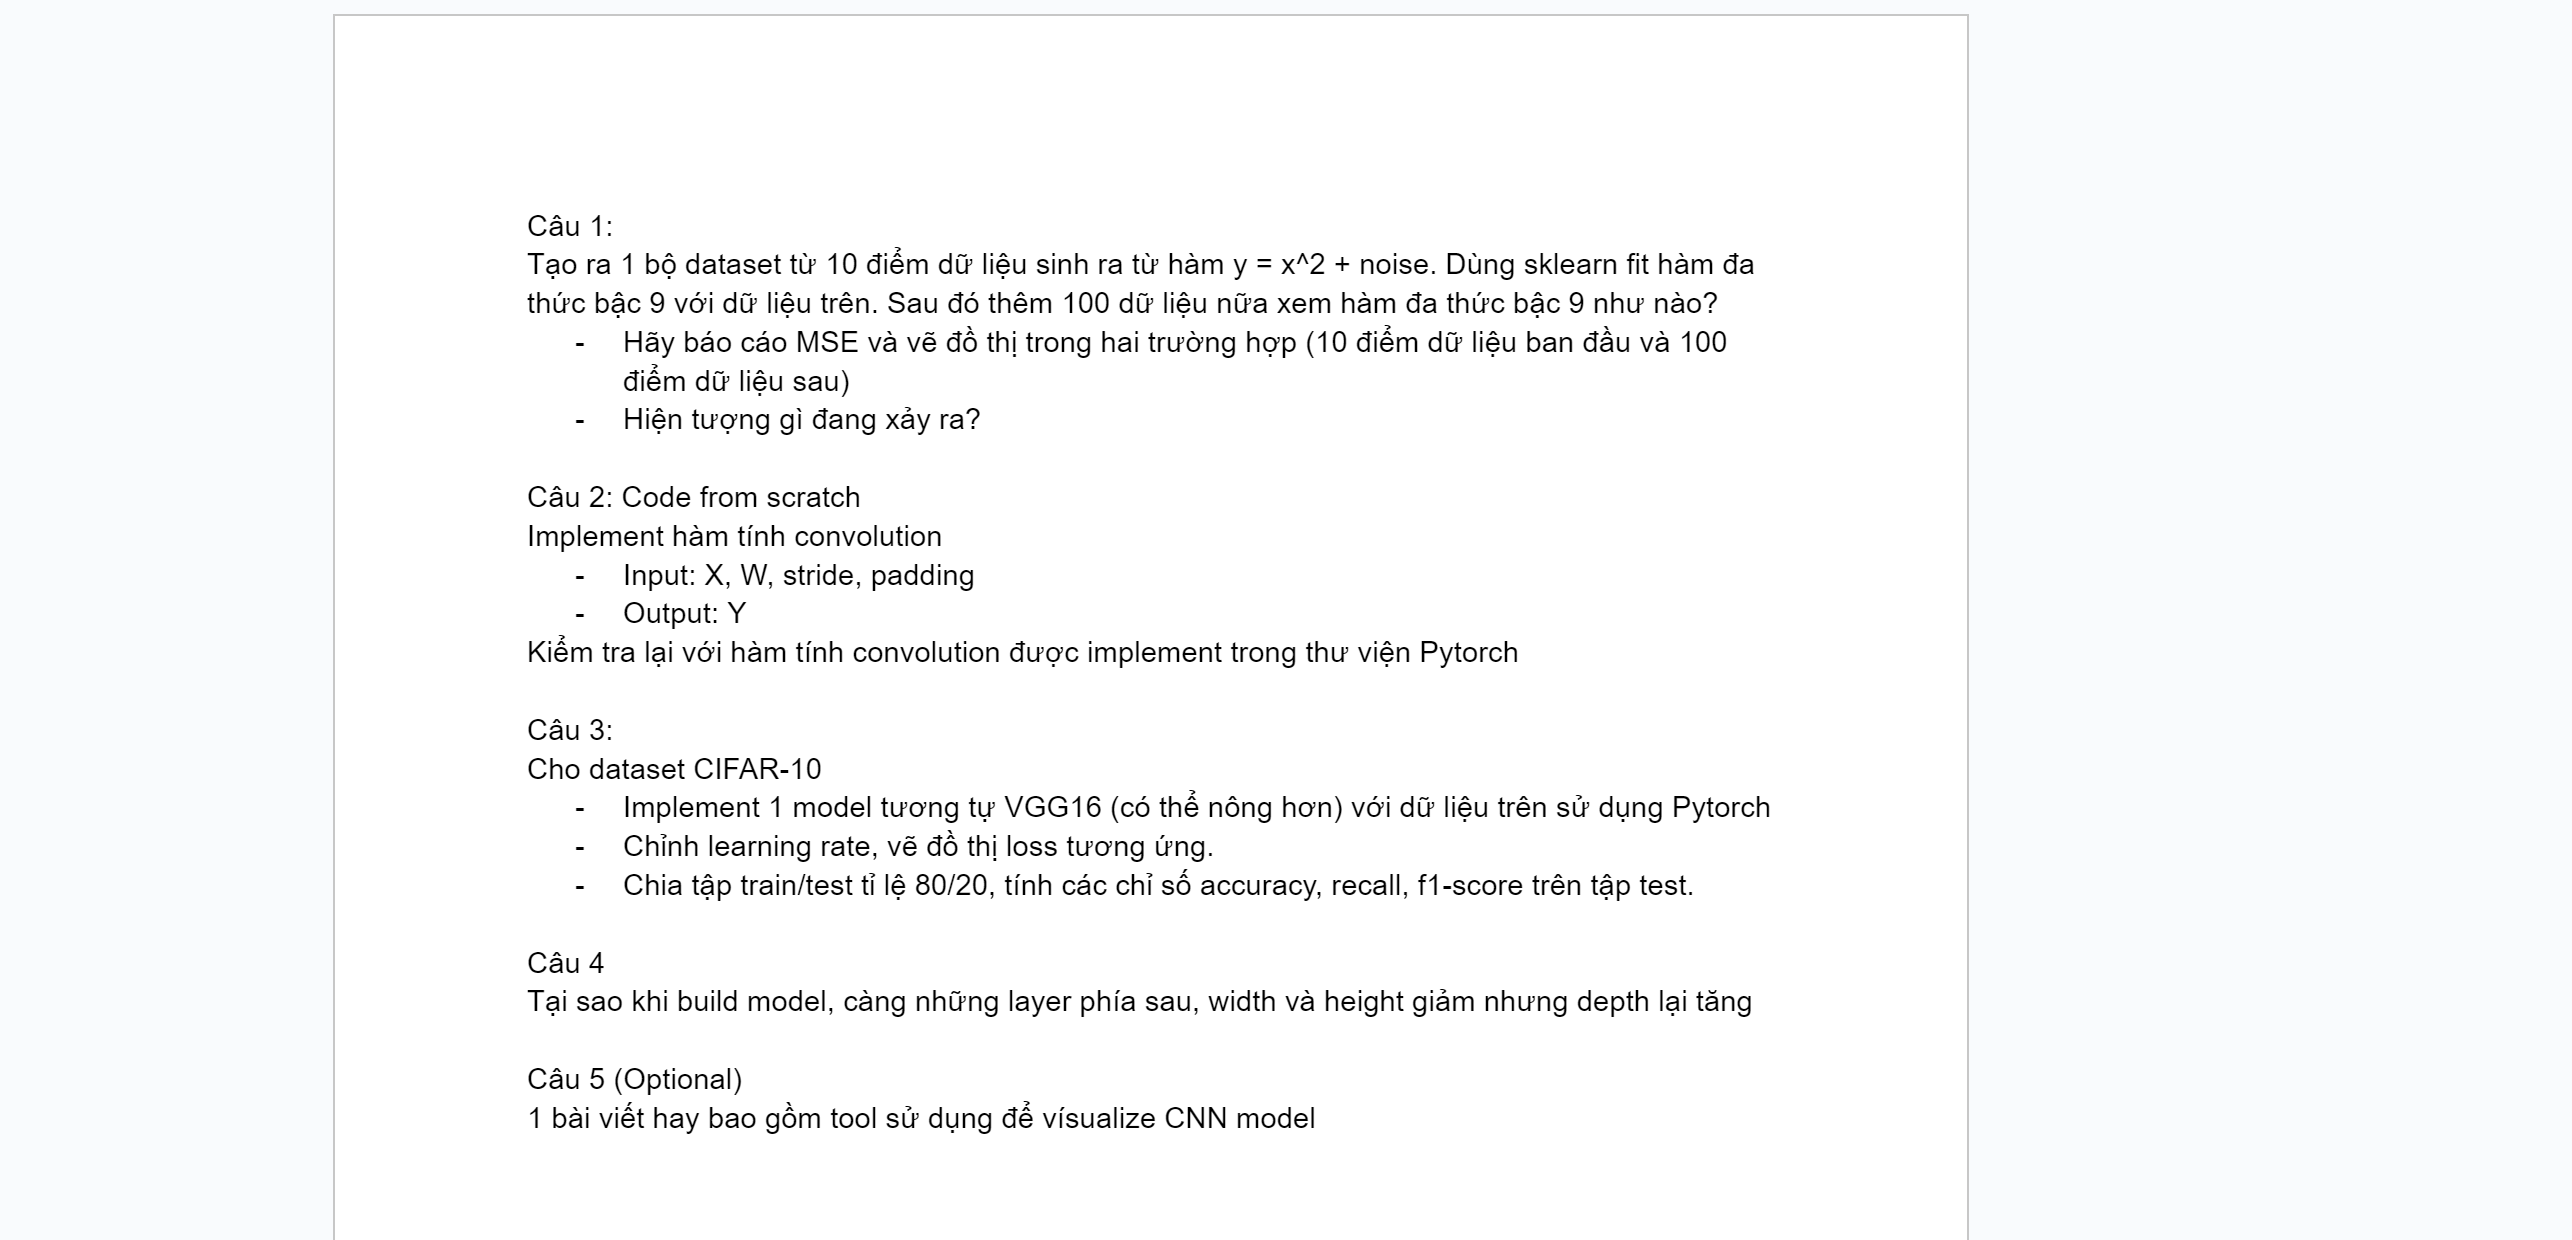

In [8]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Ex 1

MSE on original data: 8.146393801670121e-20


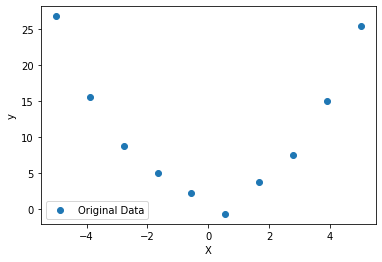

In [2]:
# Tạo dataset
np.random.seed(0)
X = np.linspace(-5, 5, 10).reshape(-1, 1)
y = X ** 2 + np.random.randn(10).reshape(-1, 1)

# Fit mô hình đa thức bậc 9
poly_features = PolynomialFeatures(degree=9)
X_poly = poly_features.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

# Tính MSE
y_pred = model.predict(X_poly)
mse = mean_squared_error(y, y_pred)
print("MSE on original data:", mse)

plt.scatter(X, y, label='Original Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

MSE on New data: 10.090927325580429


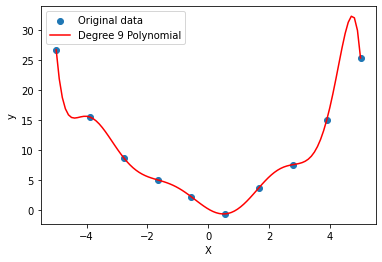

In [3]:
# Tạo 100 điểm dữ liệu mới
X_new = np.linspace(-5, 5, 100).reshape(-1, 1)
y_new = X_new ** 2 + np.random.randn(100).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
y_new_pred = model.predict(X_new_poly)

# Tính MSE
mse_new = mean_squared_error(y_new, y_new_pred)

print("MSE on New data:", mse_new)
plt.scatter(X, y, label='Original data')
plt.plot(X_new, y_new_pred, color='r', label='Degree 9 Polynomial')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
Model đang bị overfitting do bậc đa thức quá cao. Khi tăng số điểm dữ liệu thì model cho mse cao hơn, do model quá khớp với
tập dữ liệu training nhưng dự đoán sai lệch với những điểm dữ liệu mới.

## Ex 2

In [8]:
def convolution(X, W, stride=1, padding=0):
    #size X
    m, n = X.shape

    #size W
    k_row, k_col = W.shape #kernel row, column

    #size output Y
    Y_row = int((m - k_row + 2 * padding) / stride) + 1
    Y_col = int((n - k_col + 2 * padding) / stride) + 1

    #Tạo output matrix Y
    Y = np.zeros((Y_row, Y_col))

    # Thêm padding cho đầu vào nếu cần
    if padding > 0:
        X = np.pad(X, padding, mode='constant')

    # Tính convolution
    for i in range(0, Y_row):
        for j in range(0, Y_col):
            vert_start = i * stride
            vert_end = vert_start + k_row
            horiz_start = j * stride
            horiz_end = horiz_start + k_col

            X_slice = X[vert_start:vert_end, horiz_start:horiz_end]
            Y[i, j] = np.sum(X_slice * W)

    return Y

In [14]:
X = np.array([[1, 1, 1, 0, 0],
              [0, 1, 1, 1, 0],
              [0, 0, 1, 1, 1],
              [0, 0, 1, 1, 0],
              [0, 1, 1, 0, 0]])
W = np.array([[1,0,1],
              [0,1,0],
              [1,0,1]])
convolution(X, W)

array([[4., 3., 4.],
       [2., 4., 3.],
       [2., 3., 4.]])

In [19]:
#kiểm tra lại
X = torch.tensor([[1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 0],
                  [0, 0, 1, 1, 1],
                  [0, 0, 1, 1, 0],
                  [0, 1, 1, 0, 0]], dtype= torch.float32).unsqueeze(0).unsqueeze(0)
W = torch.tensor([[1,0,1],
                  [0,1,0],
                  [1,0,1]], dtype= torch.float32).unsqueeze(0).unsqueeze(0)
conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0, bias=False)
conv.weight.data = W
Y = conv(X)
print(Y.squeeze().detach().numpy())

[[4. 3. 4.]
 [2. 4. 3.]
 [2. 3. 4.]]


## Ex 3

### Implement CNN with CIFAR-10

In [5]:
# Định nghĩa mô hình CNN
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

#training
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(trainloader.dataset)
    return epoch_loss

#testing
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return epoch_loss, accuracy, recall, f1

In [4]:
#Set up data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Chỉnh learning rate và vẽ đồ thị loss

Epoch 1/10: Train Loss: 2.3028, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 2/10: Train Loss: 2.3027, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 3/10: Train Loss: 2.3027, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 4/10: Train Loss: 2.3027, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 5/10: Train Loss: 2.3026, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 6/10: Train Loss: 2.3027, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 7/10: Train Loss: 2.3026, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 8/10: Train Loss: 2.3027, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 9/10: Train Loss: 2.3027, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 10/10: Train Loss: 2.3026, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.10

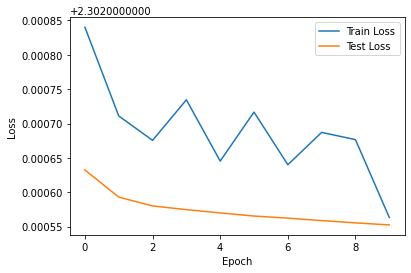

In [20]:
# Thiết lập tham số
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.001

# Khởi tạo mô hình và đưa nó vào thiết bị
model = VGG16().to(device)

# Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Huấn luyện mô hình
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer, device)
    test_loss, accuracy, recall, f1 = test(model, testloader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Vẽ đồ thị loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10: Train Loss: 2.2437, Test Loss: 1.9681, Accuracy: 0.2546, Recall: 0.2546, F1-score: 0.2019
Epoch 2/10: Train Loss: 1.7407, Test Loss: 1.4391, Accuracy: 0.4624, Recall: 0.4624, F1-score: 0.4427
Epoch 3/10: Train Loss: 1.4154, Test Loss: 1.3991, Accuracy: 0.4941, Recall: 0.4941, F1-score: 0.4935
Epoch 4/10: Train Loss: 1.2233, Test Loss: 1.1301, Accuracy: 0.5951, Recall: 0.5951, F1-score: 0.5930
Epoch 5/10: Train Loss: 1.1204, Test Loss: 1.0711, Accuracy: 0.6252, Recall: 0.6252, F1-score: 0.6159
Epoch 6/10: Train Loss: 1.0877, Test Loss: 1.0164, Accuracy: 0.6585, Recall: 0.6585, F1-score: 0.6587
Epoch 7/10: Train Loss: 1.0972, Test Loss: 1.0711, Accuracy: 0.6423, Recall: 0.6423, F1-score: 0.6368
Epoch 8/10: Train Loss: 1.1613, Test Loss: 1.2333, Accuracy: 0.5790, Recall: 0.5790, F1-score: 0.5720
Epoch 9/10: Train Loss: 1.2947, Test Loss: 1.3989, Accuracy: 0.5237, Recall: 0.5237, F1-score: 0.5193
Epoch 10/10: Train Loss: 1.4965, Test Loss: 1.4667, Accuracy: 0.4947, Recall: 0.49

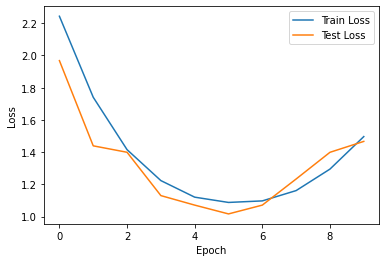

In [5]:
# Thiết lập tham số
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.1

# Khởi tạo mô hình và đưa nó vào thiết bị
model = VGG16().to(device)

# Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Huấn luyện mô hình
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer, device)
    test_loss, accuracy, recall, f1 = test(model, testloader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Vẽ đồ thị loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10: Train Loss: 2.3024, Test Loss: 2.2284, Accuracy: 0.1900, Recall: 0.1900, F1-score: 0.1153
Epoch 2/10: Train Loss: 1.8558, Test Loss: 1.5213, Accuracy: 0.4118, Recall: 0.4118, F1-score: 0.3801
Epoch 3/10: Train Loss: 1.4248, Test Loss: 1.2218, Accuracy: 0.5567, Recall: 0.5567, F1-score: 0.5442
Epoch 4/10: Train Loss: 1.1236, Test Loss: 0.9346, Accuracy: 0.6690, Recall: 0.6690, F1-score: 0.6676
Epoch 5/10: Train Loss: 0.9059, Test Loss: 0.8348, Accuracy: 0.7157, Recall: 0.7157, F1-score: 0.7132
Epoch 6/10: Train Loss: 0.7557, Test Loss: 0.7825, Accuracy: 0.7410, Recall: 0.7410, F1-score: 0.7377
Epoch 7/10: Train Loss: 0.6454, Test Loss: 0.6712, Accuracy: 0.7693, Recall: 0.7693, F1-score: 0.7701
Epoch 8/10: Train Loss: 0.5560, Test Loss: 0.6734, Accuracy: 0.7767, Recall: 0.7767, F1-score: 0.7766
Epoch 9/10: Train Loss: 0.4944, Test Loss: 0.6786, Accuracy: 0.7767, Recall: 0.7767, F1-score: 0.7761
Epoch 10/10: Train Loss: 0.4493, Test Loss: 0.6439, Accuracy: 0.7935, Recall: 0.79

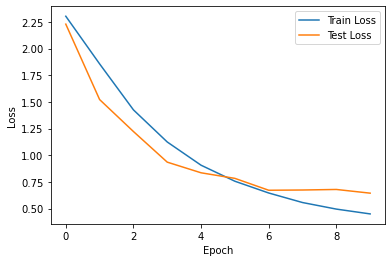

In [10]:
# Thiết lập tham số
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.05

# Khởi tạo mô hình và đưa nó vào thiết bị
model = VGG16().to(device)

# Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Huấn luyện mô hình
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer, device)
    test_loss, accuracy, recall, f1 = test(model, testloader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Vẽ đồ thị loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Chia train-test và tính accuracy, f1, recall

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
data = torch.utils.data.ConcatDataset([trainset, testset])
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Epoch 1/5: Train Loss: 2.3028, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 2/5: Train Loss: 2.3028, Test Loss: 2.3026, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 3/5: Train Loss: 2.3028, Test Loss: 2.3025, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 4/5: Train Loss: 2.3027, Test Loss: 2.3025, Accuracy: 0.1000, Recall: 0.1000, F1-score: 0.0182
Epoch 5/5: Train Loss: 2.3025, Test Loss: 2.3023, Accuracy: 0.1098, Recall: 0.1098, F1-score: 0.0324


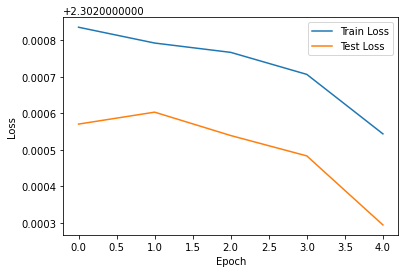

In [13]:
# Thiết lập tham số
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
learning_rate = 0.005

# Khởi tạo mô hình và đưa nó vào thiết bị
model = VGG16().to(device)

# Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Huấn luyện mô hình
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer, device)
    test_loss, accuracy, recall, f1 = test(model, testloader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Vẽ đồ thị loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Ex 4
Tại sao khi build model, càng những layer phía sau, width và height giảm nhưng depth lại tăng?

- Kích thước layers giảm dần giúp giảm số lượng tham số của mô hình và giúp tạo ra những mạng có kích thước nhẹ hơn và tốc độ dự báo nhanh hơn.
- Depth tăng lên bởi vì khi mô hình đi sâu hơn, chúng ta thường thêm vào các layer convolutional và pooling để trích xuất thông tin cấp cao. Độ sâu tăng sẽ giúp cho mạng CNN học được đa dạng các đặc trưng hơn. Càng ở những layers sau đòi hỏi độ chi tiết cao hơn thì yêu cầu số lượng bộ lọc nhiều hơn để giúp phân biệt được nhiều chi tiết đặc trưng hơn.